## Libraries

In [1]:
from Libs.load_data import DataLoader, get_dataset_split
from Libs.config import models_data_folder
from Libs.models import make_cnn, make_lstm

import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, auc, roc_curve

2023-03-27 10:10:05.576269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 10:10:05.754980: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 10:10:05.755011: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-27 10:10:07.686596: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Dataframe building
The dataset used for all the experiments has been computed as shown in the data inspection notebook. In particular here we leveraged the advantages of the synthetic dataset by incrementing the number of runs of a pre defined set of parameters (shown below) that were considered pyhisically reasonable in the original paper

In [2]:
data_loader = DataLoader(run=100, N=1000, s=0.5, t=0.01, d=0.2, m=1, override=False, folder=models_data_folder)
params = data_loader.get_params()
params

{'run': 100,
 'sigma': [0.5],
 'theta': [0.01],
 'mu': [1],
 'delta': [0.2],
 'N': 1000}

In [3]:
Xs, best_labels = data_loader.get_grid()

For all experiments, a fixed window size and a variable overlap of values were selected: 0, 5, 10, 15, 19, allowing the results between the different models to be compared for each overlap value.

The division of the time series into train, val and test was performed in separate runs in order to avoid any loss of data between the training and test models.

The manually selected threshold for defining the window as a flare window was chosen as 1; this choice can be revised simply by modifying a parameter in the dataframe definition.

In [4]:
dataset_split_params = {
    'window_size': 20, # how large is the window
    'overlap_size': None, # how many time interval of overlap there is between the windows
    'label_treshold': 1, # how many labels have to be at 1 in the window_size to consider the current window as a flare
    'split_on_run': True, # if True the windows of a run cannot be on different sets
    'shuffle_run': False, # if True shuffles the order of the runs before computing the windows
    'shuffle_window': False, # if True shuffles the order of the windows in the resulting dataframes
    'test_size': 0.3, # size of the test set expressed in percentage
    'val_size': 0.2, # size of the validation set expressed in percentage, considered only if get_validation is True
    'get_validation': True, # if True the output would be train,val,test set, otherwise it would be train,test
    'random_state': 42 # sets the seed for reproducibility
}

All results in terms of F1-Macro and AUC for each of the 7 models (5 simple, 2 neural) for the 5 chosen overlap values are saved.

In [5]:
results = {}

models_folder = "models"
overlaps = [0, 5, 10, 15, 19]
for overlap_size in overlaps:
    dataset_split_params['overlap_size'] = overlap_size
    df_train, df_val, df_test = get_dataset_split(Xs, best_labels, **dataset_split_params)

    X_train, y_train = df_train.iloc[:,:-1].to_numpy(), df_train.future_flare.to_numpy()
    X_val, y_val = df_val.iloc[:,:-1].to_numpy(), df_val.future_flare.to_numpy()
    X_test, y_test = df_test.iloc[:,:-1].to_numpy(), df_test.future_flare.to_numpy()

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_std = scaler.transform(X_train)
    X_val_std = scaler.transform(X_val)
    X_test_std = scaler.transform(X_test)
    # Make the data uniform to multivariate timeseries
    X_train_cnn = X_train_std.reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
    X_val_cnn = X_val_std.reshape((X_val_std.shape[0], X_val_std.shape[1], 1))
    X_test_cnn = X_test_std.reshape((X_test_std.shape[0], X_test_std.shape[1], 1))
    
    results[overlap_size] = {}
    
    overlap_folder = os.path.join(models_folder, f'overlap_{overlap_size}')
    for m in os.listdir(overlap_folder):
        filename, extension = m.split('.')
        if extension != 'pickle':
            if extension == 'pkl':
                model_type = filename.split('_')[-1]
                clf = joblib.load(os.path.join(overlap_folder, m))
                y_pred = clf.predict(X_test)
            if extension == 'h5':
                model_type = filename.split('_')[0].lower()
                if  model_type == 'cnn':
                    model = make_cnn(input_shape=X_train_cnn.shape[1:], num_classes=2)
                if model_type == 'lstm':
                    model = make_lstm((X_train_std.shape[1], 1))
                model.load_weights(os.path.join(overlap_folder, m))
                if model_type == 'cnn':
                    y_pred = np.round(model.predict(X_test_cnn), 0)
                if model_type == 'lstm':
                    y_pred = np.round(model.predict(X_test_std), 0)
            fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
            results[overlap_size][model_type] = {}
            results[overlap_size][model_type]['f1_macro'] = f1_score(y_test, y_pred, average='macro')
            results[overlap_size][model_type]['auc'] = auc(fpr, tpr)
                
results

2023-03-27 10:10:19.396686: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-27 10:10:19.396745: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-27 10:10:19.396812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5166cf34c918): /proc/driver/nvidia/version does not exist
2023-03-27 10:10:19.397080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


901/901 [==============================] - 7s 7ms/step


{0: {'cnn': {'f1_macro': 0.8654513888888888, 'auc': 0.8211883872035758},
  'dt': {'f1_macro': 0.8865640709057236, 'auc': 0.863065430617059},
  'knn': {'f1_macro': 0.8673563245156484, 'auc': 0.8272824152630055},
  'lp': {'f1_macro': 0.8117277501027982, 'auc': 0.7427730414269751},
  'nb': {'f1_macro': 0.8597675373531555, 'auc': 0.8368269668501428},
  'svc': {'f1_macro': 0.8600487634970393, 'auc': 0.9019989239746721},
  'lstm': {'f1_macro': 0.8600502676589634, 'auc': 0.8425433514050407}},
 5: {'cnn': {'f1_macro': 0.8820804536858246, 'auc': 0.8307857142857143},
  'dt': {'f1_macro': 0.890576041688784, 'auc': 0.8681428571428571},
  'knn': {'f1_macro': 0.8923532139466073, 'auc': 0.856},
  'lp': {'f1_macro': 0.8573426573426572, 'auc': 0.7985714285714286},
  'nb': {'f1_macro': 0.8677385203818331, 'auc': 0.8563571428571428},
  'svc': {'f1_macro': 0.872433724016755, 'auc': 0.9030714285714286},
  'lstm': {'f1_macro': 0.8888315415891654, 'auc': 0.8656428571428573}},
 10: {'cnn': {'f1_macro': 0.8694

## Plots

AUC and F1-Macro curves for each model at varying overlap

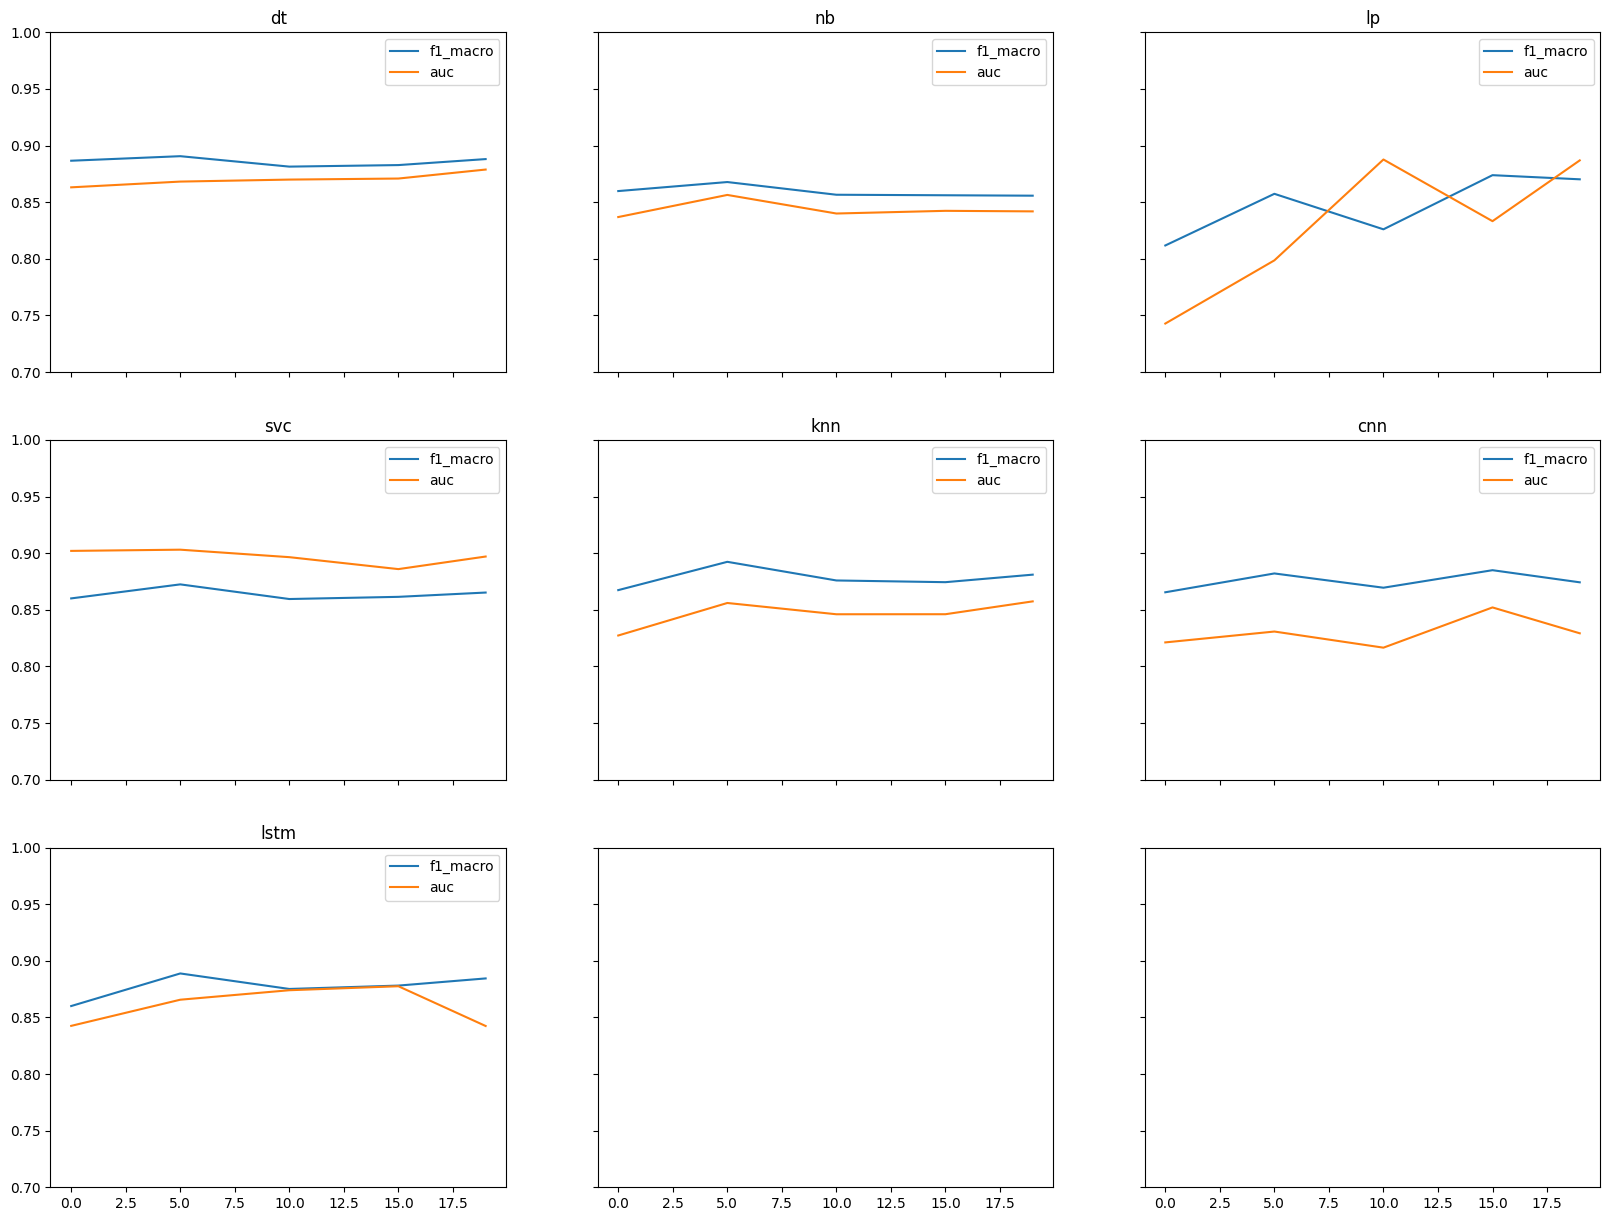

In [6]:
plt.rcParams["figure.figsize"] = (20,15)
model_lbls = ['dt', 'nb', 'lp', 'svc', 'knn', 'cnn', 'lstm']
fig, axs = plt.subplots(3, 3, sharex='all', sharey='all')
plt.setp(axs, ylim=(0.7, 1))
for idx in range(len(model_lbls)):
    i = idx // 3
    j = idx % 3
    axs[i, j].plot(overlaps, [results[x][model_lbls[idx]]['f1_macro'] for x in overlaps], label='f1_macro')
    axs[i, j].plot(overlaps, [results[x][model_lbls[idx]]['auc'] for x in overlaps], label='auc')
    axs[i, j].legend()
    axs[i, j].title.set_text(model_lbls[idx])
plt.show()

We choose to plot a barplot of the results of the models for the best performing overlap in terms of the mean of f1_macro scores of the models.
In this case KNN is the best model in term of f1_macro and SVC is the best model in term of auc.

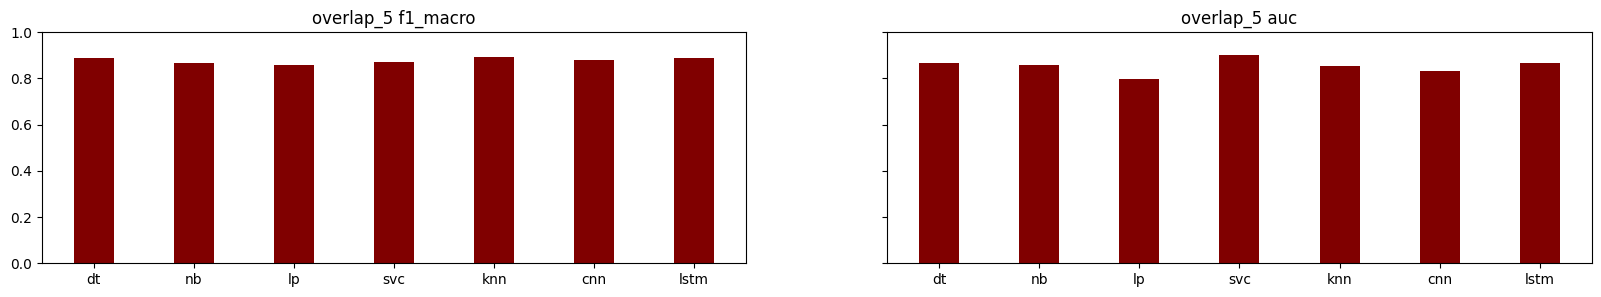

In [9]:
max_f1_m = 0
max_overlap = 0
for overlap in overlaps:
    mean_f1_m = np.mean([results[overlap][m]['f1_macro'] for m in model_lbls])
    if mean_f1_m > max_f1_m:
        max_f1_m = mean_f1_m
        max_overlap = overlap
plt.rcParams["figure.figsize"] = (20,3)
fig, axs = plt.subplots(1, 2, sharex='all', sharey='all')
plt.setp(axs, ylim=(0, 1))
axs[0].bar(model_lbls, [results[max_overlap][m]['f1_macro'] for m in model_lbls], color ='maroon', width = 0.4)
axs[1].bar(model_lbls, [results[max_overlap][m]['auc'] for m in model_lbls], color ='maroon', width = 0.4)
axs[0].title.set_text(f'overlap_{max_overlap} f1_macro')
axs[1].title.set_text(f'overlap_{max_overlap} auc')
plt.show()

Here we can see all the barplots for all the overlaps

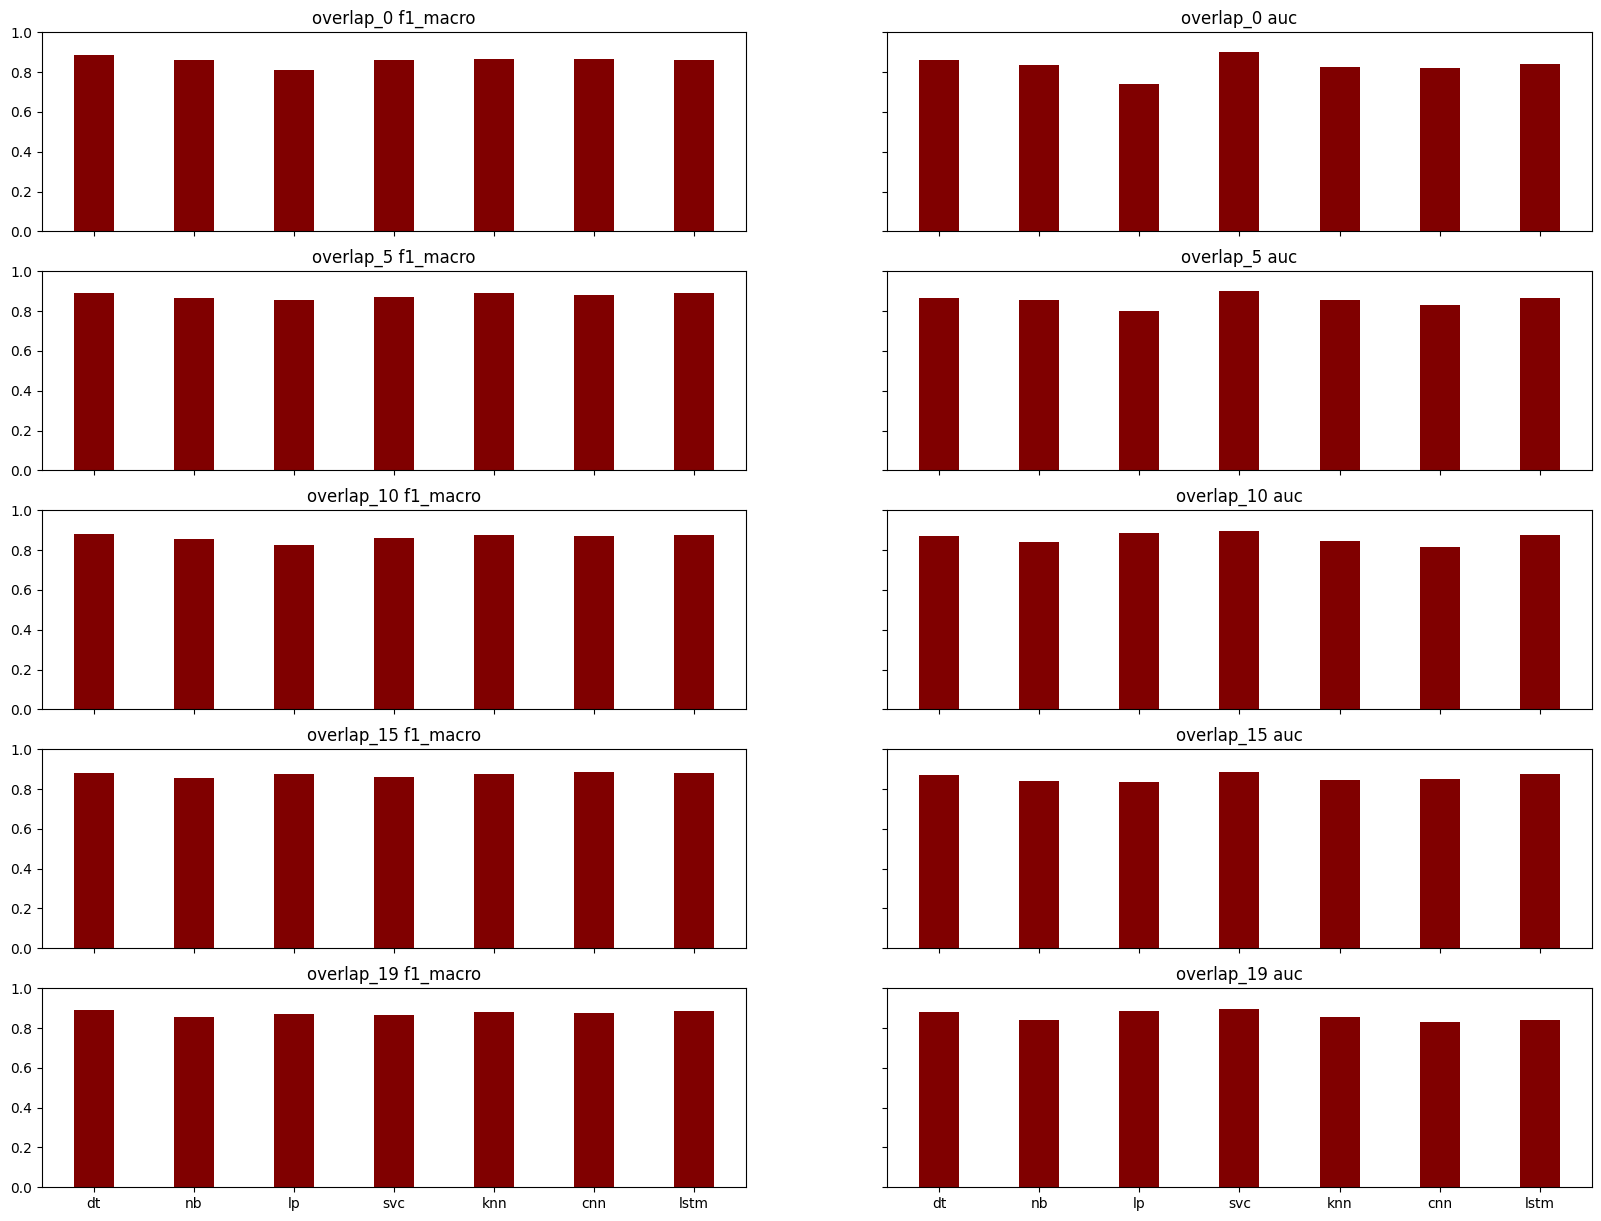

In [8]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(5, 2, sharex='all', sharey='all')
plt.setp(axs, ylim=(0, 1))
for i in range(len(overlaps)):
    axs[i,0].bar(model_lbls, [results[overlaps[i]][m]['f1_macro'] for m in model_lbls], color ='maroon', width = 0.4)
    axs[i,1].bar(model_lbls, [results[overlaps[i]][m]['auc'] for m in model_lbls], color ='maroon', width = 0.4)
    axs[i, 0].title.set_text(f'overlap_{overlaps[i]} f1_macro')
    axs[i, 1].title.set_text(f'overlap_{overlaps[i]} auc')
plt.show()

# Bibliography
\[1\] _On the distribution of fluxes of gamma-ray blazars: hints for a stochastic process?_, Tavecchio et al., [https://arxiv.org/pdf/2004.09149.pdf](https://arxiv.org/pdf/2004.09149.pdf)
<!-- cite with: [\[1\]](https://arxiv.org/pdf/2004.09149.pdf)  -->
\[2\] _Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline_, Wang et al., [https://arxiv.org/abs/1611.06455](https://arxiv.org/abs/1611.06455)
<!-- cite with: [\[2\]](https://arxiv.org/abs/1611.06455)  -->
\[3\] _Solar Flare Prediction Based on the Fusion of Multiple Deep-learning Models_, Tang et al., [https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta](https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta)
<!-- cite with: [\[3\]](https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta)  -->
\[4\] _Predicting Solar Energetic Particles Using SDO/HMI Vector Magnetic Data Products and a Bidirectional LSTM Network_, Abduallah et al., [https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta](https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta)
<!-- cite with: [\[4\]](https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta) -->